# Introduction

For this part of the assignment, we are going to implment first visit MC prediction and the temporal difference method. We are going to test these two methods on the Blackjack environment, which involves your algorithm playing blackjack (a card game) against the computer dealer. We start by taking a look at the blackjack environment [documentation](https://gym.openai.com/envs/Blackjack-v0/). 

In [ ]:
import gym
import time
import numpy as numpy
import matplotlib.pyplot as plt

def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

query_environment("Blackjack-v0")

Action Space: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Max Episode Steps: None
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


The game of blackjack can be described as follow


**Objective**: Have your card sum be greater than the dealers without exceeding 21. All face cards are counted as 10, and the ace can count either as 1 or as 11.
**States:** current sum (12-21), dealer's showing card (ace, 2-10), do I have a usable ace?

**Reward:** +1 for winning, 0 for a draw, -1 for losing 

**Actions:** stick (stopping receiving cards), hit (receive another card)

If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable.

We are going to evaluate the following policy 

**Policy:** stick if my sum is 20 or 21, else hit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym

env = gym.make('Blackjack-v0')

# First visit MC 

We are first going to implment the First visit MC algorithm. 
The pseudocode given in Sutton's reinforcement learning book is (indeed the same as in the lecture notes) 

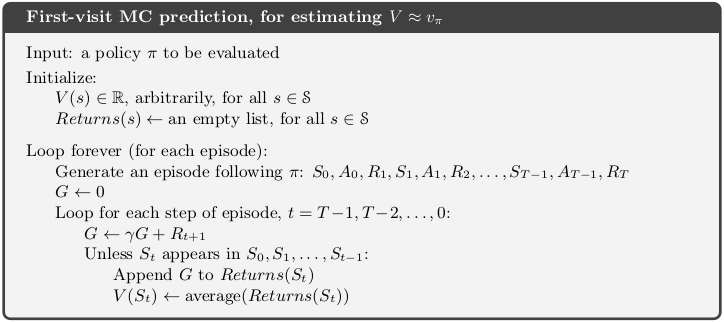

In [ ]:
def policy(St):
    p_sum, d_card, p_ace = St
    if p_sum >= 20:
        return 0  # stick
    else:
        return 1  # hit
        
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done, _ = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [ ]:
def first_visit_MC_prediction(env, policy, ep, gamma):
    """First Visit MC Prediction
    Params:
        env - environment
        policy - function in a form: policy(state)->action
        ep - number of episodes to run
        gamma - discount factor
    """
    # V = dict()
    # Returns = defaultdict(list)    # dict of lists
    r_sum = defaultdict(float)
    r_count = defaultdict(float)
    r_V = defaultdict(float)

    S = []

    for _ in range(ep):
        ###############################################################################
        # TODO: Implement the first visit MC prediction.                              #
        # You will need to do the following:                                          #
        # (1) Use the generate episode function to generate trajectory                #
        #      under the described policy                                             #
        # (2) Loop through each step of the trajectory and implement the update       #
        #      rule according to the pseudocode code                                  #
        ###############################################################################
        
        trajectory, T = generate_episode(env, policy)
        for visit_pos, data in enumerate(trajectory):
          state_visit = data[0]
          G = sum([x[2] * np.power(gamma, i) for i, x in enumerate(trajectory[visit_pos:])])
          
          if (state_visit not in S):
            S.append(state_visit)
            r_sum[state_visit] += G
            r_count[state_visit] += 1.0
            r_V[state_visit] = r_sum[state_visit] / r_count[state_visit]

  
          
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    
    return r_V

Now we are going to run the algorithm and visualize its performance.

In [ ]:
def convert_to_arr(V_dict, has_ace):
    V_dict = defaultdict(float, V_dict)  # assume zero if no key
    V_arr = np.zeros([10, 10])  # Need zero-indexed array for plotting 
    
    # convert player sum from 12-21 to 0-9
    # convert dealer card from 1-10 to 0-9
    for ps in range(12, 22):
        for dc in range(1, 11):
            V_arr[ps-12, dc-1] = V_dict[(ps, dc, has_ace)]
    return V_arr

def plot_3d_wireframe(axis, V_dict, has_ace):
    Z = convert_to_arr(V_dict, has_ace)
    dealer_card = list(range(1, 11))
    player_points = list(range(12, 22))
    X, Y = np.meshgrid(dealer_card, player_points)
    axis.plot_wireframe(X, Y, Z)
    
def plot_blackjack(V_dict):
    fig = plt.figure(figsize=[16,3])
    ax_no_ace = fig.add_subplot(121, projection='3d', title='No Ace')
    ax_has_ace = fig.add_subplot(122, projection='3d', title='With Ace')
    ax_no_ace.set_xlabel('Dealer Showing'); ax_no_ace.set_ylabel('Player Sum')
    ax_has_ace.set_xlabel('Dealer Showing'); ax_has_ace.set_ylabel('Player Sum')
    plot_3d_wireframe(ax_no_ace, V_dict, has_ace=False)
    plot_3d_wireframe(ax_has_ace, V_dict, has_ace=True)
    plt.show()


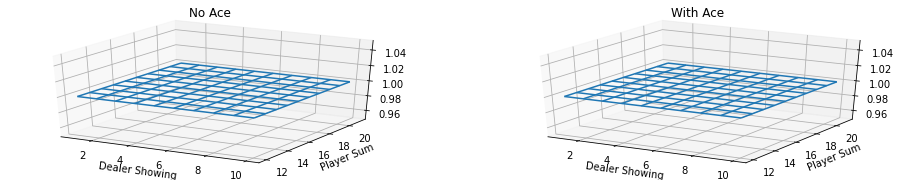

In [ ]:
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d

env = gym.make('Blackjack-v0')
V = first_visit_MC_prediction(env, policy, ep=20000, gamma=1.0)
plot_blackjack(V)

# Temporal Difference Learning

We are now going to implement the TD(0) algorithm. However, there is a problem with Blackjack environment in the gym with TD learning. If agent sticks, then environment will return exactly the same observation but this time with done==True. This will cause TD prediction to evaluate terminal state to non-zero value belonging to non-terminal state with same observation. We fix this by redefining observation for terminal states with 'TERMINAL'.

In [ ]:
class BlackjackFixed():
    def __init__(self):
        self._env = gym.make('Blackjack-v0')
        
    def reset(self):
        return self._env.reset()
    
    def step(self, action):
        obs, rew, done, _ = self._env.step(action)
        if done:
            return 'TERMINAL', rew, True  # (obs, rew, done)         <-- SUPER IMPORTANT
        else:
            return obs, rew, done
        return self._env.step(action)

Now we are ready to implement and test the TD(0) algorithm. The pseudocode given in Sutton's reinforcement learning book is (indeed the same as in the lecture notes)  
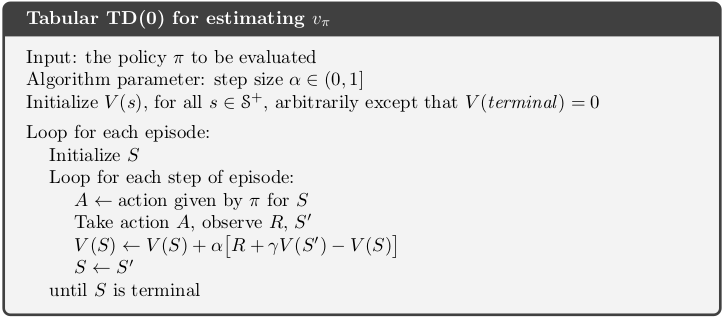

In [ ]:
def td_prediction(env, policy, ep, gamma, alpha):
    V = defaultdict(float)    # default value 0 for all states
    
    for _ in range(ep):
        S = env.reset()
        ###############################################################################
        # TODO: Implement the TD(0) algorithm.                                        #
        # You will need to do the following:                                          #
        # (1) Use the described policy to interact with the environment               #
        # (2) implement the update rule according to the pseudocode code              #
        ###############################################################################
        
        
        while True:
          # === time step starts here ===
          done = True
          if done:  St, Rt, done    = env.reset(), None, False
          else:     St, Rt, done, _ = env.step(At)
          At = policy(St)
          St_next, Rt, done = env.step(At)
          V[St] = V[St] + alpha * (Rt + gamma * V[St_next] - V[St])


          if done:  break
          # === time step ends here ===

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
                
    return V

We now test the TD(0) algorithm and plot the results. Please note that it is expected for the algorithm to run for some times (around 8 minutes for my implementation)

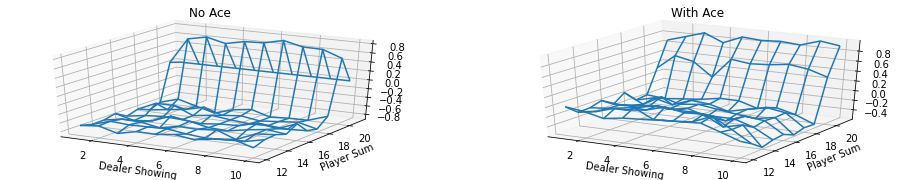

In [ ]:
env = BlackjackFixed()
V = td_prediction(env, policy, ep=10000, gamma=1.0, alpha=0.05)
plot_blackjack(V)

## **Compare first visit MC with TD(0). Under which case would first visit MC be more efficient and under which case would TD(0) be more efficient**
TD(0) suffers from bias on the initial conditions of the learning parameters, the bootstrapping process typically update a function using whatever the current estimate are in the latter. Clearly at the very start of learning these estimates contain no information from any real rewards or state transitions.
If learning works as intended, then the bias will reduce asymptotically over multiple iterations. However, the bias can cause significant problems, especially for off-policy methods (e.g. Q Learning) and when using function approximators.
Monte Carlo control methods do not suffer from this bias, as each update is made using a true sample of what Q(s,a) should be. However, Monte Carlo methods can suffer from high variance, which means more samples are required to achieve the same degree of learning compared to TD.